# Duquesne Light Heating Rate + Heat Pump

Model the heat pump savings for single family occupied homes in the Duquesne Light Territory with the flat default residential rate and the seasonal electric heating rate.

This also provides a good template of a simple rate analysis, highlighting cells where updates should be made, and providing many example plots.

TODO: Refactor some of these commonly used plotting functions into another file. 

In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
import numpy as np
from itertools import chain
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
import pyspark.sql.functions as F
import seaborn as sns
import sys

from IPython.display import display, HTML

sys.path.append("../../src")

from rates.rate_widgets import RateScheduleWidget
from rates.rate_structure import FlatRateSchedule, RateSchedule
from rates.modeled_rate import ModeledRate, compute_total_energy_costs, compute_savings
from rates.utility_selector_functions import create_electric_utility_widget, select_county_geoids_in_utility

In [0]:
pd.options.display.float_format = "{:,.2f}".format
spark.conf.set("spark.databricks.io.cache.enabled", "true")

In [0]:
# general constants

# paths
RATE_STRUCTURE_FPATH = pathlib.Path() / "rate.json"

# some useful conversion factors
KILOWATT_HOUR_TO_THERM = 0.0341295634
THERM_TO_MCF = 0.09643
KILOWATT_HOUR_TO_GALLON_OF_PROPANE = 0.0373
KILOWATT_HOUR_TO_GALLON_OF_FUEL_OIL = 3412.14 / 138500

## Define Geography of Interest

In [0]:
# NOTE: Update This Section!
# Create widget for selecting electric utility 
selector = create_electric_utility_widget("PA", "Duquesne Light Co")

In [0]:
# Counties that selected utility serves in selected state according for EIA Form 861 for 2023
utility_county_geoids = select_county_geoids_in_utility(selector)

Counties in Duquesne Light Co: ['ALLEGHENY', 'BEAVER', 'WESTMORELAND']


## Pull in Load Profiles

In [0]:
BASELINE_UPGRADE_ID = 0.01 # We are using ResStock 2024.2 only
# NOTE: Update This: Add upgrades of interest
HP_UPGRADE_ID = 11.07  # Medium efficiency heat pump (SEER 18, HSPF 10 ducted; SEER 18, HSPF 10.5 ductless)

UPGRADES = [
    BASELINE_UPGRADE_ID,
    HP_UPGRADE_ID, 
]

In [0]:
# NOTE: Update This Section!
# Filter to buildings of interest along with metadata of interest: Right now SF Occupied homes in the utility territory with modeled fuels and without baseline heat pumps
metadata_columns = [
    "in_heating_fuel",
    "in_hvac_cooling_type",
    "in_water_heater_fuel",
    "in_area_median_income",
]  # metadata of interest to analyze results by

filtered_buildings = (
    spark.table("building_model.resstock_metadata_2024_2")
    .where(F.col("in_geometry_building_type_acs").startswith("Single"))
    .where(~F.col("in_is_vacant"))
    .where(F.col("in_heating_fuel") != "Other Fuel")
    .where(~F.col("in_hvac_heating_appliance_type").isin(["ASHP", "MSHP"]))
    .where(F.col("county_geoid").isin(utility_county_geoids))
).select("building_id", *metadata_columns)

building_list = list(filtered_buildings.select("building_id").toPandas()["building_id"])
print(f"Found {len(building_list)} matching buildings.")

Found 2253 matching buildings.


In [0]:
# Pull timeseries for upgrades of interest
building_load_profiles = (
    spark.table("building_model.resstock_ra_outputs_hourly")
    .where(F.col("upgrade_id").isin([*UPGRADES]))
    # Note: Filtering by county when reading the hourly data makes this much faster!
    # Other building characteristics can be filtered for when joining with the building metadata.
    .where(F.col("county_geoid").isin(utility_county_geoids))
    .where(F.col("building_id").isin(building_list))
    .where(F.col("building_set") == "ResStock 2024.2")
    .select(
        "building_id",
        "upgrade_id",
        "day",
        "month",
        "hour",
        F.col("out_electricity_total_energy_consumption_kwh").alias("electricity_kwh"),
        F.col("out_natural_gas_total_energy_consumption_kwh").alias("natural_gas_kwh"),
        F.col("out_propane_total_energy_consumption_kwh").alias("propane_kwh"),
        F.col("out_fuel_oil_total_energy_consumption_kwh").alias("fuel_oil_kwh"),
    )
)

In [0]:
# subset load profiles to buildings of interest and load into memory
# we'll also keep the heating baseline type in case we want to apply the heating rate
# for baseline electric resistance housholds 
filtered_building_load_profiles = building_load_profiles.join(F.broadcast(filtered_buildings.select('building_id', "in_heating_fuel")), on="building_id")

load_profiles_pd = filtered_building_load_profiles.select(
    F.col("upgrade_id").cast("float"),
    "building_id",
    "in_heating_fuel",
    "day",
    "month",
    "hour",
    "electricity_kwh",
    "natural_gas_kwh",
    "propane_kwh",
    "fuel_oil_kwh",
).toPandas()

In [0]:
# check if there are any delivered fuels present in this territory
if load_profiles_pd[load_profiles_pd.upgrade_id == BASELINE_UPGRADE_ID].fuel_oil_kwh.sum() == 0:
    print("No fuel oil use for any homes in this subset, can skip modeling this fuel")
if load_profiles_pd[load_profiles_pd.upgrade_id == BASELINE_UPGRADE_ID].propane_kwh.sum() == 0:
    print("No propane use for any homes in this subset, can skip modeling this fuel")

## Define Rates

#### Set up rate constants

In [0]:
# NOTE: Update this section with any flat rates for electric or gas 
# 1. Electricity -- Duquesne Light 
# Source: https://duquesnelight.com/docs/default-source/default-document-library/currenttariff_90_25.pdf?_gl=1*61ifsj*_gcl_au*MTE5NTQ1NTc2OC4xNzQzODU2ODY3*_ga*ODE5NjE0MzMxLjE3NDM4NTY4Njg.*_ga_W3XVZZ5JY5*MTc0NDAyMzk0MC4zLjEuMTc0NDAyMzk1My4wLjAuMA..#page=44.59
ELECTRICITY_CUSTOMER_CHARGE_MONTHLY = 13
ELECTRICITY_SUPPLY_CHARGE = .097093
ELECTRICITY_RESIDENTIAL_RATE_PER_KWH = .082479

# alternatively can pull gas rates from the directly from the cube
UTILITY_NAME = 'Peoples Gas Company'
gas_rates_dict = (
    spark.table('rates.utility_average_rates_and_fixed_charges')
    .where(F.col('utility_name') == UTILITY_NAME)
    .where(F.col('state') == selector['state'])
    .select('fixed_charge', 'volumetric_charge').toPandas().to_dict(orient='index')[0]
)
gas_rates_dict

{'fixed_charge': 17.532006510739777, 'volumetric_charge': 0.04372486627145413}

In [0]:
# read in volumetric rate for delivered fuels for selected state for each fuel in $/kwh
fossil_fuel_cost = (
    spark.table("geographic_summary.average_real_energy_prices")
    .where(F.col("in_state") == selector['state'])
    .where(F.col("fuel").isin(['propane', 'fuel_oil']))
    .select("fuel", F.col("price").alias("volumetric_rate"))
).toPandas()

# convert to dict of fuel -> cost factor
fuel_to_volumetric_rate = fossil_fuel_cost.set_index("fuel").to_dict()["volumetric_rate"]
fuel_to_volumetric_rate

{'propane': 0.11530944159262176, 'fuel_oil': 0.09538881516659314}

### Define Time Varying Rate Structure if hasn't been saved to to file

NOTE: If rate structure has already been saved, can proceed directly to Next Section: Calculate Bills

In [0]:
# NOTE: Update This Section!
# Set up a new rate schedule.
widget = RateScheduleWidget(RateSchedule.from_json_file(RATE_STRUCTURE_FPATH))
# widget = RateScheduleWidget() # Alternatively can just initialize a rate from scratch
# Note: volumetric rates here include energy charge + supply charge

In [0]:
# Get the RateSchedule object out of the widget.
time_varying_electric_rate = widget.get_rate_schedule()

In [0]:
# write rate schedule to file if it doesnt already exist
if not RATE_STRUCTURE_FPATH.exists():
    time_varying_electric_rate.to_json_file(RATE_STRUCTURE_FPATH)

else:
    print(f"{RATE_STRUCTURE_FPATH} already exists")


rate.json already exists


## Calculate Bills



#### Electricity

In [0]:
# Read in saved TOU rate and display

# Source for delivery charge (p45), which is then added to the supply charge to get total volumetric rate: https://duquesnelight.com/docs/default-source/default-document-library/currenttariff_90_25.pdf?_gl=1*61ifsj*_gcl_au*MTE5NTQ1NTc2OC4xNzQzODU2ODY3*_ga*ODE5NjE0MzMxLjE3NDM4NTY4Njg.*_ga_W3XVZZ5JY5*MTc0NDAyMzk0MC4zLjEuMTc0NDAyMzk1My4wLjAuMA..#page=44.59
display(HTML(time_varying_electric_rate.schedule_html))

In [0]:
# NOTE: Update this Section to model specific electric rate x upgrade combinations
# It is important to provide a rate name for each electric rate you are modeling
# so that we can compare them later!

# First we'll model  all all baseline & upgrades under flat electric rate
flat_electric_rate_schedule = FlatRateSchedule(
    # Sums to $0.179572
    volumetric_rate=ELECTRICITY_RESIDENTIAL_RATE_PER_KWH + ELECTRICITY_SUPPLY_CHARGE,
    monthly_fixed_charge=ELECTRICITY_CUSTOMER_CHARGE_MONTHLY,
)

electricity = ModeledRate.create_modeled_rate_per_upgrade(
    load_profile_upgrades_df=load_profiles_pd,
    rate_schedule = flat_electric_rate_schedule,
    name="Residential"
)

# Then we'll model the HP upgrade under the electric heating rate
# append it to the dictionary containing all the other modeled rates by upgrade
electricity_hp_time_varying = ModeledRate(
    load_profile_df=load_profiles_pd[load_profiles_pd.upgrade_id == HP_UPGRADE_ID],
    rate_schedule = time_varying_electric_rate,
    name="Residential Heating",
)

electricity[HP_UPGRADE_ID] = electricity_hp_time_varying

#### Natural Gas

In [0]:
# NOTE: Update This Section to plug in alternative gas rates!
# Only one rate per fossil fuel is currently supported

# Model all upgrades under flat gas rates
flat_gas_rate_schedule = FlatRateSchedule(
    volumetric_rate=gas_rates_dict['volumetric_charge'],
    monthly_fixed_charge=gas_rates_dict['fixed_charge'],
)

gas_flat = ModeledRate.create_modeled_rate_per_upgrade(
    load_profile_upgrades_df=load_profiles_pd,
    rate_schedule = flat_gas_rate_schedule,
    fuel='natural_gas'
)

#### Propane



In [0]:
# Model all upgrades under flat state-wide propane rate
propane_rate_schedule = FlatRateSchedule(volumetric_rate=fuel_to_volumetric_rate["propane"])

propane_flat = ModeledRate.create_modeled_rate_per_upgrade(
    fuel="propane",
    rate_schedule=propane_rate_schedule,
    load_profile_upgrades_df=load_profiles_pd,
)

#### Fuel Oil

In [0]:
# Model all upgrades under flat state-wide fuel oil rate
fuel_oil_rate_schedule = FlatRateSchedule(volumetric_rate=fuel_to_volumetric_rate["fuel_oil"])

fuel_oil_flat = ModeledRate.create_modeled_rate_per_upgrade(
    fuel="fuel_oil",
    rate_schedule=fuel_oil_rate_schedule,
    load_profile_upgrades_df=load_profiles_pd,
)

## Results!

In [0]:
# compute costs for each (upgrade, fuel) and combine!

# list of (upgrade_id, ModeledRate) pairs
combined_modeled_rates = list(
    chain(
        electricity.items(),
        gas_flat.items(),
        propane_flat.items(),
        fuel_oil_flat.items()
    )
)

granularity = "annual"
# granularity = 'monthly_hourly' -- could change to different granularities
bills_by_building_upgrade_fuel_rate = pd.concat(
    [
        model.to_long_format(upgrade_id=float(upgrade_id), granularity=granularity)
        for upgrade_id, model in combined_modeled_rates
    ]
)

bills_by_building_upgrade_fuel_rate.head()

,building_id,energy,cost,upgrade_id,fuel,rate_name
0,182047,"6,279.36","1,283.60",0.01,electricity,Residential
1,182864,"6,455.24","1,315.18",0.01,electricity,Residential
2,185442,"21,667.42","4,046.86",0.01,electricity,Residential
3,186659,"9,245.21","1,816.18",0.01,electricity,Residential
4,188594,"8,686.58","1,715.87",0.01,electricity,Residential


In [0]:
# Compute totals over all fuels
total_bills_by_building_upgrade_rate = compute_total_energy_costs(bills_by_building_upgrade_fuel_rate)
total_bills_by_building_upgrade_rate.head()

,building_id,energy,cost,upgrade_id,rate_name
0,182047,"56,232.10","3,678.16",0.01,Residential
1,182864,"46,663.16","3,283.65",0.01,Residential
2,185442,"21,667.42","4,046.86",0.01,Residential
3,186659,"41,914.03","3,455.00",0.01,Residential
4,188594,"36,317.44","3,349.51",0.01,Residential


In [0]:
# Calculate the savings across all fuels under each combination of baseline and upgrade rate
savings_by_building_upgrade_electric_rate = compute_savings(
    total_bills_by_building_upgrade_rate, baseline_upgrade_id= BASELINE_UPGRADE_ID
)
savings_by_building_upgrade_electric_rate.head()

,building_id,energy,cost,upgrade_id,rate_name,energy_baseline,cost_baseline,rate_name_baseline,energy_savings,cost_savings,has_positive_savings
0,2136,"24,713.09","3,506.44",11.07,Residential,"41,583.93","3,853.12",Residential,"16,870.83",346.68,True
1,2136,"24,713.09","3,438.13",11.07,Residential Heating,"41,583.93","3,853.12",Residential,"16,870.83",414.99,True
2,2337,"11,220.60","1,636.05",11.07,Residential,"16,579.90","1,722.26",Residential,"5,359.29",86.22,True
3,2337,"11,220.60","1,610.16",11.07,Residential Heating,"16,579.90","1,722.26",Residential,"5,359.29",112.11,True
4,3694,"23,338.80","4,347.00",11.07,Residential,"63,138.11","6,882.77",Residential,"39,799.31","2,535.77",True


In [0]:
# Example of basic result table
savings_by_building_upgrade_electric_rate.groupby(['upgrade_id', 'rate_name', 'rate_name_baseline']).agg(
    {
        "cost": ["mean", "median"],
        "cost_baseline": ["mean", "median"],
        "cost_savings": ["mean", "median"],
        "has_positive_savings": ["mean"],
    }
)

cost  ... has_positive_savings
                                                      mean  ...                 mean
upgrade_id rate_name           rate_name_baseline           ...                     
11.07      Residential         Residential        3,378.23  ...                 0.54
           Residential Heating Residential        3,298.52  ...                 0.68

[2 rows x 7 columns]

/databricks/python/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


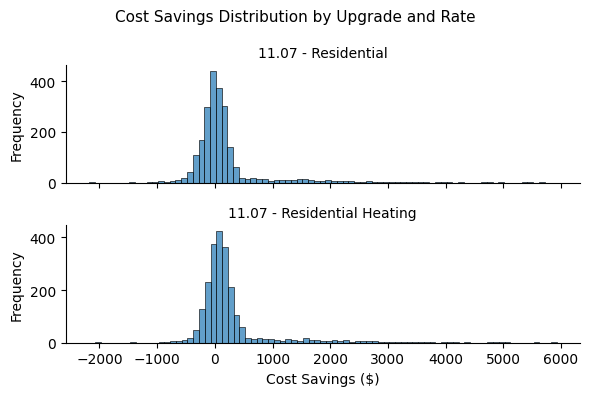

In [0]:
# Example of histogram of total household savings under each upgrade and rate

# Create a combined 'upgrade - rate' column for faceting
savings_by_building_upgrade_electric_rate['upgrade - rate'] = savings_by_building_upgrade_electric_rate['upgrade_id'].astype(str) + " - " + savings_by_building_upgrade_electric_rate['rate_name']

# Initialize FacetGrid (one row per group)
g = sns.FacetGrid(
    savings_by_building_upgrade_electric_rate,
    row='upgrade - rate',
    aspect=3,              # Width-to-height ratio per subplot
    height=2,              # Height of each row (in inches)
    sharex=True,           # Align x-axis for easy comparison
    sharey=False           # Let y-axis scale independently
)
g.fig.suptitle('Cost Savings Distribution by Upgrade and Rate', fontsize=11)

# Map histograms to each row
g.map(
    sns.histplot,
    'cost_savings',
    binwidth=100,          # 1 bin per $100
    alpha=0.7
)

# Customize titles and labels
g.set_titles(row_template="{row_name}")  # Show group name as row title
g.set_axis_labels("Cost Savings ($)", "Frequency")
g.tight_layout()

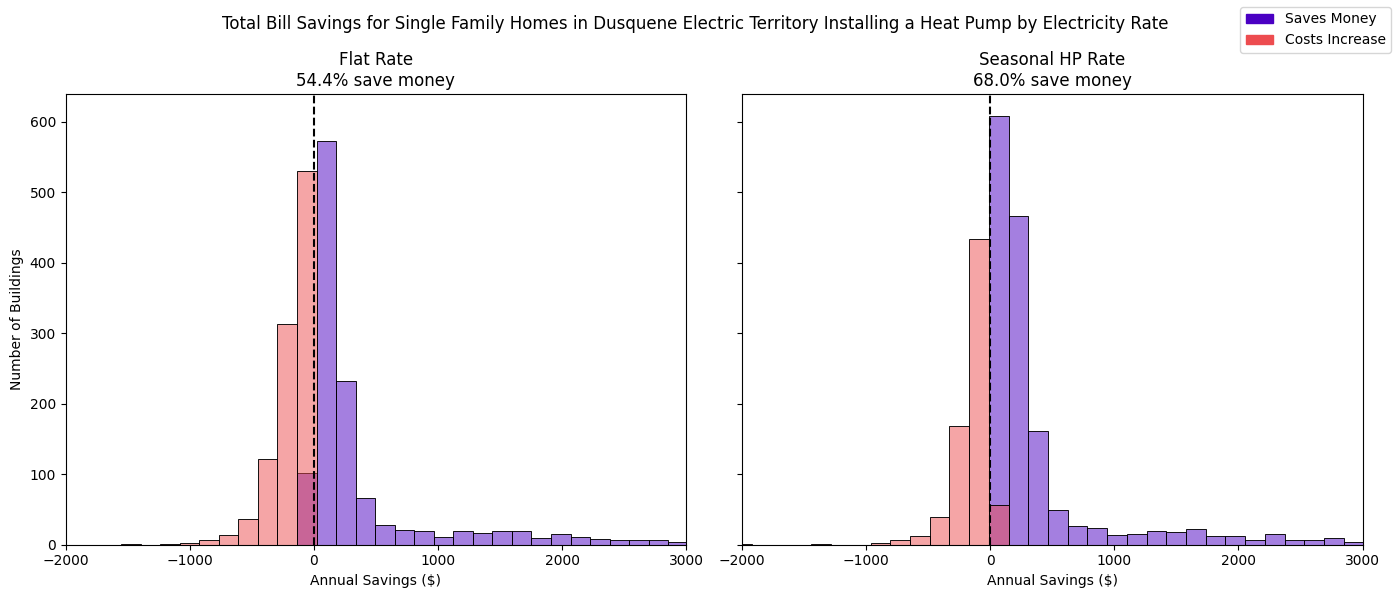

In [0]:
# Example of more complex histgram for heat pump upgrade only shaded by whether household savings are positive or negative
hp_savings_rs = savings_by_building_upgrade_electric_rate[
    (savings_by_building_upgrade_electric_rate.upgrade_id==HP_UPGRADE_ID) &
    (savings_by_building_upgrade_electric_rate.rate_name == "Residential")
]
hp_savings_rs_heating = savings_by_building_upgrade_electric_rate[
    (savings_by_building_upgrade_electric_rate.upgrade_id==HP_UPGRADE_ID) &
    (savings_by_building_upgrade_electric_rate.rate_name == "Residential Heating")
]


saves_flat = (hp_savings_rs.cost_savings > 0).mean()

saves_heating = (hp_savings_rs_heating.cost_savings > 0).mean()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
bins = 50
saver_color = "#4A00C3"
non_saver_color = "#ed4c4f"

# Standard Rate
sns.histplot(
    data=hp_savings_rs,
    x="cost_savings",
    bins=bins,
    hue=hp_savings_rs["cost_savings"] > 0,
    palette={True: saver_color, False: non_saver_color},
    ax=ax1,
    legend=False,
)

ax1.set_title(f"Flat Rate\n{saves_flat:.1%} save money")
ax1.set_xlim(-2000, 3000)
# HP Rate
sns.histplot(
    data=hp_savings_rs_heating,
    x="cost_savings",
    bins=bins,
    hue=hp_savings_rs_heating["cost_savings"] > 0,
    palette={True: saver_color, False: non_saver_color},
    ax=ax2,
    legend=False,
)
ax2.set_title(f"Seasonal HP Rate\n{saves_heating:.1%} save money")
ax2.set_xlim(-2000, 3000)
# Shared elements
for ax in (ax1, ax2):
    ax.set_xlabel("Annual Savings ($)")
    ax.axvline(0, color="black", linestyle="--")
ax1.set_ylabel("Number of Buildings")

# Add legend
handles = [
    plt.Rectangle((0, 0), 1, 1, color=saver_color, label="Saves Money"),
    plt.Rectangle((0, 0), 1, 1, color=non_saver_color, label="Costs Increase"),
]


fig.legend(handles=handles, loc="upper right")
plt.suptitle('Total Bill Savings for Single Family Homes in Dusquene Electric Territory Installing a Heat Pump by Electricity Rate')
plt.tight_layout()

In [0]:
# Example of basic result table broken down by feature(s) of interest
CROSSTAB_FEATURES = [
    "in_heating_fuel"
]  # NOTE: update to features of interest-- must be a subset of the metadata cols selected in the Pull Load Profile Section
# Options:
#     "in_heating_fuel",
#     "in_hvac_cooling_type",
#     "in_water_heater_fuel",
#     "in_area_median_income",

building_metadata = filtered_buildings.toPandas()
building_metadata["building_id"] = building_metadata["building_id"].astype(int)
savings_by_building_upgrade_electric_rate_w_metadata = savings_by_building_upgrade_electric_rate.merge(
    building_metadata, on="building_id"
)
savings_by_building_upgrade_electric_rate_w_metadata.groupby(
    ["upgrade_id", "rate_name", "rate_name_baseline", *CROSSTAB_FEATURES]
).agg(
    {
        "cost_savings": ["mean", "median"],
        "has_positive_savings": "mean",
        "building_id": "count",
    }
)

cost_savings  ... building_id
                                                                          mean  ...       count
upgrade_id rate_name           rate_name_baseline in_heating_fuel               ...            
11.07      Residential         Residential        Electricity         2,253.29  ...          96
                                                  Fuel Oil            1,516.93  ...         116
                                                  Natural Gas           -10.72  ...        2022
                                                  None               -1,829.13  ...           2
                                                  Propane             1,524.04  ...          17
           Residential Heating Residential        Electricity         2,333.62  ...          96
                                                  Fuel Oil            1,603.44  ...         116
                                                  Natural Gas            68.65  ...        2022
                                                  None               -1,726.62  ...           2
                                                  Propane             1,591.65  ...          17

[10 rows x 4 columns]

/databricks/python/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


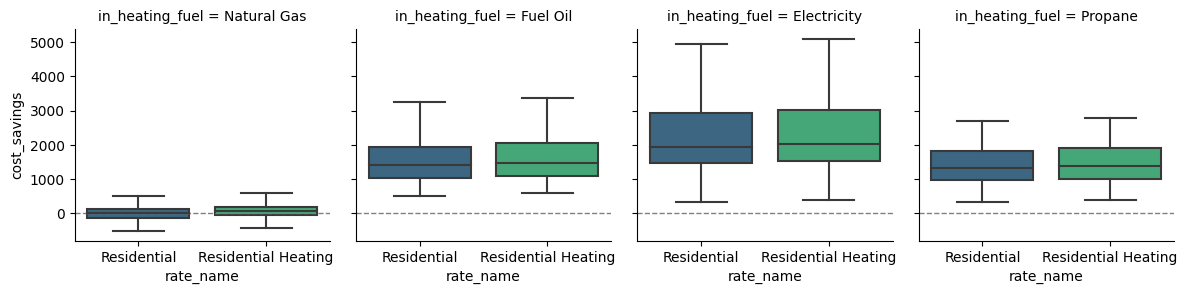

In [0]:
# Example of savings boxplot for just one upgrade broken down by feature of interest

hp_savings_by_building_electric_rate_w_metadata = savings_by_building_upgrade_electric_rate_w_metadata[
    (savings_by_building_upgrade_electric_rate_w_metadata.upgrade_id==HP_UPGRADE_ID) &
    (savings_by_building_upgrade_electric_rate_w_metadata.in_heating_fuel != "None")
]

g = sns.catplot(
    data=hp_savings_by_building_electric_rate_w_metadata,
    y="cost_savings",
    x="rate_name",
    col='in_heating_fuel',
    kind="box",
    showfliers=False,
    palette="viridis",
    height=3,
)
for ax in g.axes.flat:
    ax.axhline(y=0, color="gray", linestyle="--", linewidth=1)
g.fig.subplots_adjust(top=0.9)

#### Visualize Monthly Bills

In [0]:
# Calculate monthly bills instead
bills_by_building_upgrade_fuel_rate_month = pd.concat(
    [
        model.to_long_format(upgrade_id=float(upgrade_id), granularity='monthly')
        for upgrade_id, model in combined_modeled_rates
    ]
)

# compute totals over all fuels
total_bills_by_building_upgrade_rate_month = compute_total_energy_costs(bills_by_building_upgrade_fuel_rate_month)
total_bills_by_building_upgrade_rate_month .head()

,building_id,month,energy,cost,upgrade_id,rate_name
0,182047,1,"12,691.22",682.66,0.01,Residential
1,182047,2,"9,827.86",544.30,0.01,Residential
2,182047,3,"6,034.97",369.45,0.01,Residential
3,182047,4,"3,562.43",246.05,0.01,Residential
4,182047,5,"2,181.12",189.21,0.01,Residential


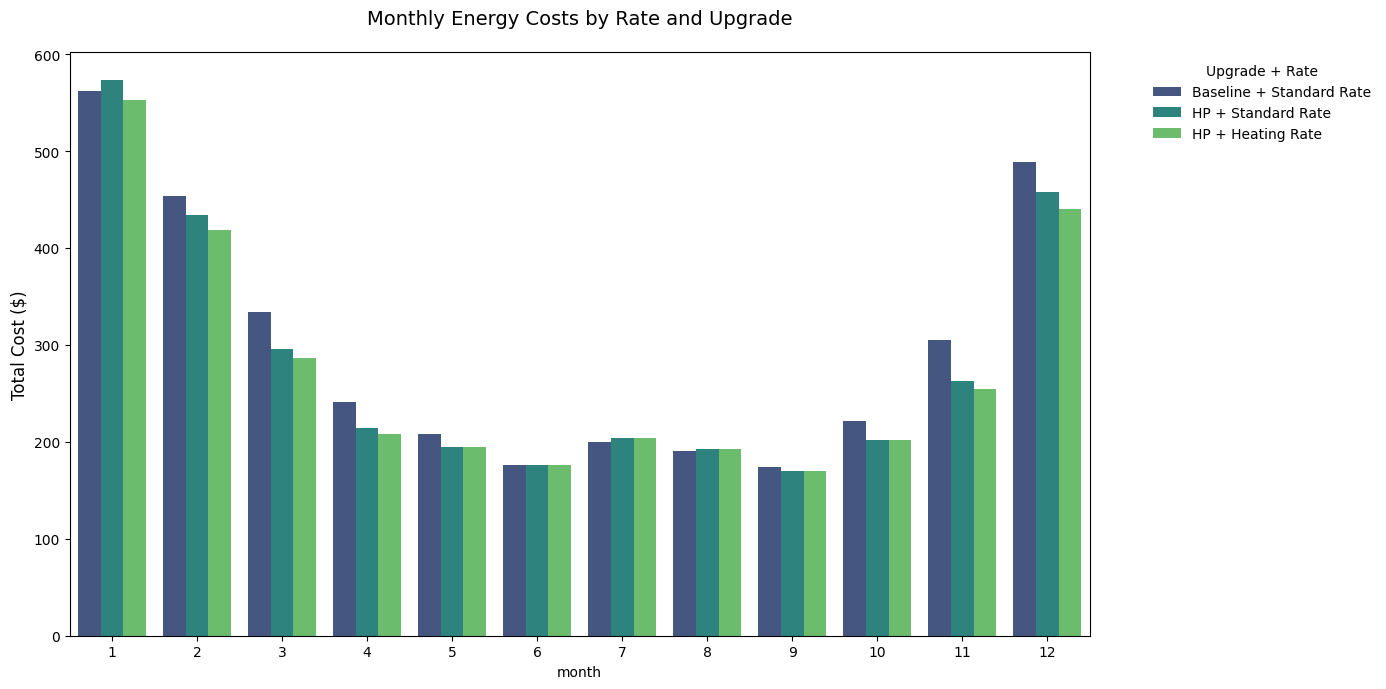

In [0]:
# Example plot of average household monthly bills for each (upgrade, rate)

# subset to baseline and heat pump only
hp_monthly_bills_by_upgrade_rate = total_bills_by_building_upgrade_rate_month [total_bills_by_building_upgrade_rate_month.upgrade_id.isin([HP_UPGRADE_ID, BASELINE_UPGRADE_ID])]


# get labels for each (upgrade, electric rate)
def get_rate_upgrade_label(row):
    if row["upgrade_id"] == BASELINE_UPGRADE_ID:
        return "Baseline + Standard Rate"
    elif row["rate_name"] == "Residential":
        return "HP + Standard Rate"
    else:
        return "HP + Heating Rate"


hp_monthly_bills_by_upgrade_rate["rate_upgrade"] = hp_monthly_bills_by_upgrade_rate.apply(
    get_rate_upgrade_label, axis=1
)

# plot monthly bills
plt.figure(figsize=(14, 7))
ax = sns.barplot(
    data=hp_monthly_bills_by_upgrade_rate,
    x="month",
    y="cost",
    hue="rate_upgrade",
    palette="viridis",
    estimator='mean',  # Sum costs if data is not pre-aggregated
    errorbar=None,  # Remove error bars
)

plt.title("Monthly Energy Costs by Rate and Upgrade", fontsize=14, pad=20)
plt.ylabel("Total Cost ($)", fontsize=12)

plt.legend(title="Upgrade + Rate", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)

plt.tight_layout()